In [81]:
# Import modules
import numpy as np

# Import functions
from local_global_matrices import *
from assembly_K_matrices import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# Import data
d = np.fromfile('data/d.dat')
fP = np.fromfile('data/fP.dat')
fr = np.fromfile('data/fr.dat')
Ks = np.genfromtxt('data/localK.dat')
solution = np.fromfile('data/solution.dat')

In [83]:
# Initial data
# Number of subdomains
Nsub_x = 4
Nsub_y = 3

# Number of remaining nodes in each subdomain
Nr_x = 4
Nr_y = 3

# Local remaining and primal indices
rs = np.array([1, 2, 4, 5, 6, 7, 9, 10])
qs = np.array([0, 3, 8, 11])

In [84]:
# Transformation matrices A
# Primal nodes local-global transformation matrices
APq = create_APq_matrices(Nsub_x, Nsub_y)

# Remaining nodes local-global transformation matrices
ARr = create_ARr_matrices(Nsub_x, Nsub_y, Nr_x, Nr_y)

In [85]:
# Stiffness matrices K
KRR = assembly_KRR_matrix(Ks, ARr, rs)
KPP = assembly_KPP_matrix(Ks, APq, qs)
KPR = assembly_KPR_matrix(Ks, APq, ARr, qs, rs)
KRP = KPR.T

In [86]:
Nr = Nr_x*Nr_y - 4  # Number of local remaining nodes r
NR = Nr*(Nsub_x*Nsub_y)  # Number of total remaining nodes R
Nr

8

In [87]:
Nlambdar = (Nsub_x*(Nr_x - 2)) * (Nsub_y - 1) + (Nsub_y*(Nr_y - 2)) * (Nsub_x - 1)
Nlambdap_Dir = 4 # hardcoded
Nlambdar_Dir = 3 # hardcoded

Nlambda = Nlambdar + Nlambdar_Dir + Nlambdap_Dir

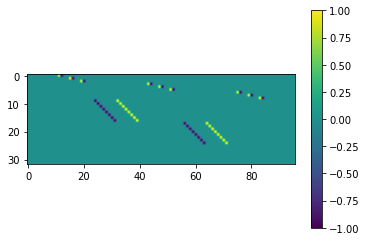

In [88]:
Nr = Nr_x*Nr_y - 4  # Number of local remaining nodes r
NR = Nr*(Nsub_x*Nsub_y)  # Number of total remaining nodes R
BlambdaR = np.zeros([Nlambda, NR])

for j in range(Nsub_y):
    for i in range(Nsub_x):
        Brs = np.zeros([Nlambda, Nr])
        # Local rs nodes in boundaries
        rs_bot = np.arange(Nr_x - 2)
        rs_top = np.arange(Nr_x - 2) + (Nr_y - 2)*Nr_x + (Nr_x - 2)
        rs_left = np.arange(Nr_x - 2, (Nr_y - 2)*(Nr_x) + Nr_x - 2, Nr_x)
        rs_right = rs_left + Nr_x - 1

        Nrs_hor = Nr_x - 2
        Nrs_ver = Nr_y - 2

        # left
        if i > 0:
            lambda_left = np.arange((i-1) + j*(Nr_y - 2)*(Nsub_x - 1), Nrs_ver*(Nsub_x - 1) + (i-1) + j*(Nr_y - 2)*(Nsub_x - 1),step=Nsub_x - 1)
            # print('left', lambda_left)
            for lambda_, rs in zip(lambda_left, rs_left):
                Brs[int(lambda_), int(rs)] = -1
        # right
        if i < Nsub_x - 1:
            lambda_right = np.arange((i) + j*(Nr_y - 2)*(Nsub_x - 1), Nrs_ver*(Nsub_x - 1) + (i) + j*(Nr_y - 2)*(Nsub_x - 1),step=Nsub_x - 1)
            # print('right', lambda_right)
            for lambda_, rs in zip(lambda_right, rs_right):
                Brs[int(lambda_), int(rs)] = 1
        # bottom
        Nlambdar_hor = (Nr_y - 2)*(Nsub_y)*(Nsub_x - 1)
        if j > 0:
            lambda_bot = np.arange(Nlambdar_hor + (j - 1)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2), Nlambdar_hor + (j - 1)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2) + (Nr_x - 2))
            # print('bot', lambda_bot)
            for lambda_, rs in zip(lambda_bot, rs_bot):
                Brs[int(lambda_), int(rs)] = 1
        # top
        if j < Nsub_y - 1:
            lambda_top = np.arange(Nlambdar_hor + (j)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2), Nlambdar_hor + (j)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2) + (Nr_x - 2))
            # print('top', lambda_top)
            for lambda_, rs in zip(lambda_top, rs_top):
                Brs[int(lambda_), int(rs)] = -1

        BlambdaR += Brs @ ARr[i + j*Nsub_x].T

plot_sparse_matrix(BlambdaR)